In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Dataset imports:
from data.moleDataset import *

# Data augmenter imports:
from data.data_augmentation import*

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print(f'Using: {torch.cuda.get_device_name(0)}')
print(f'Current device: {device}')

Using: NVIDIA GeForce GTX 1060 6GB
Current device: cuda


# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [5]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [6]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.
image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std)])

# This transform is the same as the above one but it does not convert to Tensor
# So the returned image from the dataset can be visualized easier.
image_preprocessing_test = transforms.Compose([
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

# Defining the dataset:

In [12]:
# Creating the dataset instance:
test_dataset = MoleDataset(transform=image_preprocessing)

### The dataset class distribution:

In [13]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

In [ ]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [ ]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [ ]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32)

### Creating the model:

In [ ]:
model_overfit = SkinCancerModel()

### The hyperparameters, the loss function and the optimizer:

In [ ]:
learning_rate = 1e-3
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_overfit.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
epochs = 60

### Overfitting the model:

In [ ]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

In [ ]:
figure(figsize=(5, 3), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()

# Setting up the actual model:

### Defining the Dataset object:

In [7]:
dataset = MoleDataset()

### Splitting the dataset into train, validation, and test sets:

In [8]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.8
validation_proportion = 0.1
test_proportion = 0.1

# Defining the sizes of the splits:

# 1) The train set size:
train_size = math.ceil(train_proportion * len(dataset))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(dataset))

# 3) The test set size:
test_size = math.floor(test_proportion * len(dataset))

# Defining the indecies of the train, validation and test sets:
all_indecies = np.random.choice(list(range(len(dataset))), (10, len(dataset) // 10), replace=False)

train_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(train_proportion * 10), replace=False)
val_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(validation_proportion * 10), replace=False)
test_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(test_proportion * 10), replace=False)

train_set_ind = np.append([], all_indecies[train_set_ind]).astype(np.int)
val_set_ind = np.append([], all_indecies[val_set_ind]).astype(np.int)
test_set_ind = np.append([], all_indecies[test_set_ind]).astype(np.int)

# # Defining the train, validation, and test sets:
class_threshold = 450
train_set = MoleDataset(indecies=train_set_ind, class_threshold=class_threshold)
# train_set = MoleDataset(indecies=train_set_ind)
validation_set = MoleDataset(transform=image_preprocessing, indecies=val_set_ind)
test_set = MoleDataset(transform=image_preprocessing, indecies=test_set_ind)

In [9]:
# i = 4

# # print(f'Metadata {train_set.metadata.iloc[i, :]}')
# print(f'Mapped label: {train_set.mapped_labels[i]}')
# print(f'Label from the instance: {train_set.labels[i]}')
# print(f'Label: {train_set[i][1]}')
# print(train_set[i][2])


# image = train_set[i][0]
# plt.imshow(image.permute(1, 2, 0))

In [10]:
data_dist = train_set.get_data_distribution()
print(len(train_set))
data_dist

2223


{'akiec': 253,
 'bcc': 408,
 'bkl': 450,
 'df': 93,
 'mel': 450,
 'nv': 450,
 'vasc': 119}

### Plotting the train data distribution before augmentation

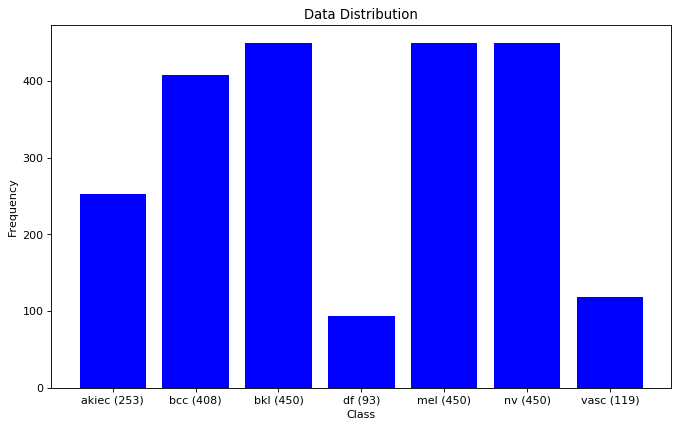

In [11]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Augmenting the training data:

In [12]:
augmentation_amount = [class_threshold - i for i in data_dist.values()]
print(f'Number of data points to be augmented: {sum(augmentation_amount)}')
augmentation_amount

Number of data points to be augmented: 927


[197, 42, 0, 357, 0, 0, 331]

In [385]:
# Getting the path where the augmented data will be placed:
augmention_path_location = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'data', 'dataset_location.txt')
augmentation_path = None
with open(augmention_path_location, 'r') as file:
    augmentation_path = json.loads(file.read())
    augmentation_path = augmentation_path['aug_data']
    
    
# Note: Uncomment this code if you want to augment new data.
# augmenter = DataAugmenter(dataset=train_set, augmentation_path=augmentation_path)
# Note: set replace to True if you want to delete the already augmented data and augment new data
# augmenter.augment_multiple_classes(list(train_set.mapping.keys()), augmentation_amount, replace=True)

class: akiec | amount augmented: 189
class: bcc | amount augmented: 52
class: bkl | amount augmented: 0
class: df | amount augmented: 360
class: mel | amount augmented: 0
class: nv | amount augmented: 0
class: vasc | amount augmented: 333


In [13]:
# train_set = MoleDataset(transform=image_preprocessing, indecies=train_set_ind, augment=True)
train_set = MoleDataset(transform=image_preprocessing, indecies=train_set_ind, augment=True, class_threshold=class_threshold)

In [14]:
data_dist = train_set.get_data_distribution()
data_dist

{'akiec': 442,
 'bcc': 450,
 'bkl': 450,
 'df': 450,
 'mel': 450,
 'nv': 450,
 'vasc': 450}

# Plotting the data distribution after the augmentation:

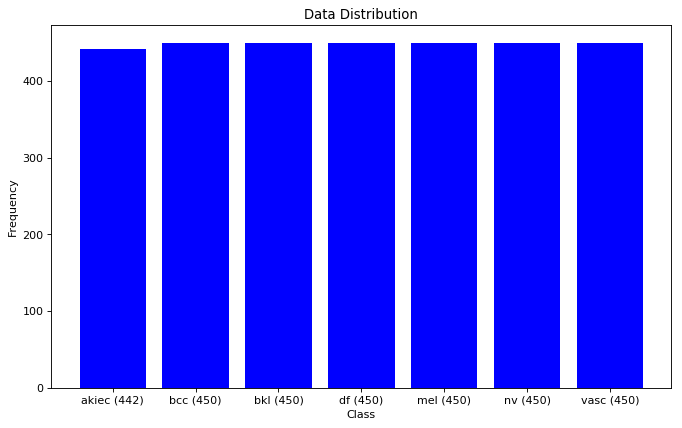

In [15]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

### Creating the DataLoader objects:

In [16]:
train_batch_size, validation_batch_size, test_batch_size = 8, 8, 16

# Setting the num_workers to the number of cores on this machine.
num_workers = 4

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers)
test_loader = DataLoader(test_set, shuffle=True, batch_size=test_batch_size, num_workers=num_workers)

### Creating the model:

In [32]:
model = SkinCancerModel()

### Defining the optimizer, criterion, and hyperparameters:

In [33]:
learning_rate = 1e-2 # 1e-3 in the previous trial.

# Getting the classes weights:
# loss_weights = torch.tensor(dataset.class_weights(), dtype=torch.float)

# Defining the optimizer:
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Defining the learning rate schedular:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # None in the previous trial.
# scheduler = None # Try without a scheduler
 
# Defining the weighted loss function:
# criterion = nn.CrossEntropyLoss(weight=loss_weights)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device=device)

### Defining the number of epochs:

In [34]:
epochs = 20 # 10 in the previous trial.

# Training the model

In [ ]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating epoch...


  5%|▌         | 1/20 [00:52<16:43, 52.84s/it]

Learning rate: 0.01
Epoch: 0 | Train_acc: 30.01% | Val_acc: 21.98% | Loss: 7546.56 | Runtime: 52.84 seconds
Evaluating epoch...


 10%|█         | 2/20 [01:45<15:53, 52.95s/it]

Learning rate: 0.01
Epoch: 1 | Train_acc: 40.39% | Val_acc: 45.25% | Loss: 719.44 | Runtime: 53.02 seconds
Evaluating epoch...


 15%|█▌        | 3/20 [02:38<14:55, 52.67s/it]

Learning rate: 0.01
Epoch: 2 | Train_acc: 48.06% | Val_acc: 51.85% | Loss: 596.93 | Runtime: 52.34 seconds
Evaluating epoch...


 20%|██        | 4/20 [03:30<14:02, 52.65s/it]

Learning rate: 0.01
Epoch: 3 | Train_acc: 51.40% | Val_acc: 43.76% | Loss: 557.81 | Runtime: 52.63 seconds
Evaluating epoch...


 25%|██▌       | 5/20 [04:23<13:09, 52.63s/it]

Learning rate: 0.01
Epoch: 4 | Train_acc: 52.77% | Val_acc: 42.76% | Loss: 526.21 | Runtime: 52.60 seconds
Evaluating epoch...


 30%|███       | 6/20 [05:16<12:20, 52.87s/it]

Learning rate: 0.01
Epoch: 5 | Train_acc: 53.66% | Val_acc: 59.74% | Loss: 501.36 | Runtime: 53.32 seconds
Evaluating epoch...


 35%|███▌      | 7/20 [06:09<11:26, 52.84s/it]

Learning rate: 0.01
Epoch: 6 | Train_acc: 61.04% | Val_acc: 48.85% | Loss: 496.37 | Runtime: 52.77 seconds
Evaluating epoch...


 40%|████      | 8/20 [07:01<10:31, 52.65s/it]

Learning rate: 0.01
Epoch: 7 | Train_acc: 67.76% | Val_acc: 59.94% | Loss: 470.16 | Runtime: 52.27 seconds
Evaluating epoch...


 45%|████▌     | 9/20 [07:53<09:35, 52.34s/it]

Learning rate: 0.01
Epoch: 8 | Train_acc: 69.03% | Val_acc: 47.65% | Loss: 436.13 | Runtime: 51.64 seconds
Evaluating epoch...


 50%|█████     | 10/20 [08:42<08:33, 51.37s/it]

Learning rate: 0.01
Epoch: 9 | Train_acc: 82.37% | Val_acc: 48.95% | Loss: 358.28 | Runtime: 49.21 seconds
Evaluating epoch...


 55%|█████▌    | 11/20 [09:31<07:35, 50.61s/it]

Learning rate: 0.001
Epoch: 10 | Train_acc: 91.53% | Val_acc: 70.83% | Loss: 146.93 | Runtime: 48.88 seconds
Evaluating epoch...


 60%|██████    | 12/20 [10:24<06:50, 51.28s/it]

Learning rate: 0.001
Epoch: 11 | Train_acc: 93.92% | Val_acc: 71.53% | Loss: 104.79 | Runtime: 52.80 seconds
Evaluating epoch...


 65%|██████▌   | 13/20 [11:13<05:54, 50.60s/it]

Learning rate: 0.001
Epoch: 12 | Train_acc: 95.89% | Val_acc: 70.43% | Loss: 80.89 | Runtime: 49.04 seconds
Evaluating epoch...


 70%|███████   | 14/20 [12:02<05:01, 50.18s/it]

Learning rate: 0.001
Epoch: 13 | Train_acc: 96.69% | Val_acc: 71.73% | Loss: 63.34 | Runtime: 49.21 seconds
Evaluating epoch...


 75%|███████▌  | 15/20 [12:51<04:09, 49.81s/it]

Learning rate: 0.001
Epoch: 14 | Train_acc: 97.77% | Val_acc: 73.53% | Loss: 49.52 | Runtime: 48.95 seconds
Evaluating epoch...


 80%|████████  | 16/20 [13:40<03:18, 49.54s/it]

Learning rate: 0.001
Epoch: 15 | Train_acc: 98.82% | Val_acc: 71.93% | Loss: 36.56 | Runtime: 48.93 seconds
Evaluating epoch...


 85%|████████▌ | 17/20 [14:30<02:29, 49.76s/it]

Learning rate: 0.001
Epoch: 16 | Train_acc: 99.01% | Val_acc: 67.93% | Loss: 25.05 | Runtime: 50.26 seconds
Evaluating epoch...


 90%|█████████ | 18/20 [15:24<01:41, 50.85s/it]

Learning rate: 0.001
Epoch: 17 | Train_acc: 99.81% | Val_acc: 71.33% | Loss: 17.28 | Runtime: 53.40 seconds
Evaluating epoch...


 95%|█████████▌| 19/20 [16:12<00:50, 50.00s/it]

Learning rate: 0.001
Epoch: 18 | Train_acc: 99.84% | Val_acc: 67.63% | Loss: 10.35 | Runtime: 48.01 seconds
Evaluating epoch...


In [ ]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.plot(accuracies_validation, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()


figure(figsize=(10, 4), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, 'go-')
plt.show()

# Evaluating the model with the test set:

In [29]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

In [30]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 63.64%
